# **Retrieval-augmented generation**

RAG is a framework that combines two important components:
- **Retrieval**: Utilizes algorithms/systems to search a knowledge base.
- **Generation**: LLMs' ability to predict probable next words based on context.

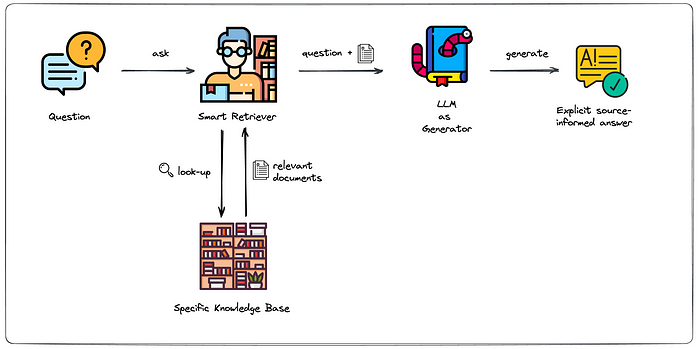


## What is the Use-Case ?
One of the most powerful applications enabled by LLMs is sophisticated question-answering (Q&A) chatbots. These are applications that can answer questions about specific source information.

Lets build an chatbot which can do a Question/Answer on bio medical research articles!

Here we have scraped 10 articles related to "Lung cancer" from pubmed.



## Building the knowledge base [ Vector database ]

### 1. Defining the Data
Get the text data which the chatbot should be using as the knowledge base.
Eg: Website, PDF, Docs, CSV etc.

[Checkout for more document loaders](https://python.langchain.com/docs/modules/data_connection/document_loaders/)

In [8]:
import os
import xml.etree.ElementTree as ET

folder_path = "./lung-cancer-10"
text_contents = ""

for filename in os.listdir(folder_path):
    if filename.endswith(".xml"):
        file_path = os.path.join(folder_path, filename)
        with open(file_path, 'r', encoding='utf-8') as file:
            xml_content = file.read()
            tree = ET.ElementTree(ET.fromstring(xml_content))
            root = tree.getroot()
            body = root.find('.//body')
            if body is not None:
                text_contents += ''.join(body.itertext())

print(text_contents[0:20000])



    
      Introduction
      Lung cancer is the most common cancer and the leading cause of cancer-related death worldwide1. The 5-year overall survival rate in patients with stage I non-small cell lung cancer is approximately 80%2. However, most patients with stage I lung cancer are asymptomatic and are thus unlikely to be diagnosed. In fact, about 75% of lung cancers are diagnosed as locally advanced or metastatic disease (stage III or IV), which are associated with poorer overall survival (37 and 6%, respectively)2. Therefore, early detection is essential for decreasing lung cancer-related mortality.
      Computed tomography (CT) has been shown to be an effective method for lung cancer screening of high-risk populations. The National Lung Screening Trial revealed that high-risk participants who underwent CT screening had a 20% decrease in lung cancer mortality3. Based on this result, in 2014, the United States Preventive Services Task Force (USPSTF) released recommendations for l

### 2. Chunking
Chunking involves breaking down texts into smaller, manageable pieces called "chunks." Each chunk becomes a unit of information that is vectorized and stored in a database.
- Chunk size is the maximum number of characters that a chunk can contain.
- Chunk overlap is the number of characters that should overlap between two adjacent chunks.

[Checkout chunking techniques](https://www.rungalileo.io/blog/mastering-rag-advanced-chunking-techniques-for-llm-applications)

In [9]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=600,
    chunk_overlap=100,
)
chunked_texts = text_splitter.split_text(text_contents)
print(len(chunked_texts))

/Users/geethaselvam/workspace/genai_workspace/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1146


### 3. Embedding
Embedding is a means of representing objects like text, images and audio as points in a continuous vector space.

[More on embedding](https://www.ibm.com/topics/embedding)

In [30]:
import openai

api_key = "xyz"
openai.api_key = api_key
response = openai.embeddings.create(
    input=chunked_texts,
    model="text-embedding-3-small"
)
embeddings = [data.embedding for data in response.data]
print(response.data[0].embedding)

[0.03134972229599953, -0.043071553111076355, 0.048726584762334824, 0.020643601194024086, -0.01649840921163559, -0.03439684957265854, -0.041946038603782654, 0.0357145257294178, -0.028632014989852905, 0.025269195437431335, 0.044526487588882446, -0.00744624575600028, -0.012373806908726692, -0.028302595019340515, 0.049714840948581696, 0.03261249512434006, -0.08125672489404678, 0.034287042915821075, 0.04941287264227867, 0.04587161913514137, 0.0281927902251482, 0.04224800691008568, -0.04455393925309181, 0.017129795625805855, -0.0059947422705590725, -0.010033558122813702, -0.030910497531294823, 0.04507552087306976, 0.03403997793793678, -0.07549189031124115, 0.03047127276659012, -0.02907123975455761, 0.00867470446974039, 0.008654115721583366, 0.004344215150922537, -0.006701620761305094, 0.0437578447163105, -0.01570231281220913, -0.0007158861844800413, 0.010980638675391674, 0.04136955738067627, -0.05040113255381584, -0.0013425546931102872, 0.03307917341589928, -0.0036133164539933205, -0.0053839

### 4. Create Vector Database
A vector database indexes and stores vector embeddings for fast retrieval and similarity search, with capabilities like CRUD operations, metadata filtering, horizontal scaling, and serverless.

[Comparison of vector database](https://www.datacamp.com/blog/the-top-5-vector-databases)

In [16]:
from qdrant_client import QdrantClient
from qdrant_client.models import Distance, VectorParams, PointStruct

# creating an chroma vector db instance and collection
# client = QdrantClient(path="db")
client = QdrantClient(":memory:")

# store the embeddings created in the collection
client.create_collection(
    collection_name="test_collection",
    vectors_config=VectorParams(size=1536, distance=Distance.COSINE),
)

client.upsert(
    collection_name="test_collection",
    points=[
        PointStruct(
            id=idx,
            vector=embedding,
            payload={"text": chunked_texts[idx]}
        )
        for idx, embedding in enumerate(embeddings)
    ]
)

UpdateResult(operation_id=0, status=<UpdateStatus.COMPLETED: 'completed'>)

### 5. Vector Search
Vector search is a method of information retrieval where documents and queries are represented as vectors instead of plain text.

[Vector Similarity beyond Search](https://qdrant.tech/articles/vector-similarity-beyond-search/#vector-similarity-beyond-search)

In [18]:
# Function to search the database
def vector_search(query, top_k=4):

  # create embedding of the query
  response = openai.embeddings.create(
      input=query,
      model="text-embedding-3-small"
  )
  query_embeddings = response.data[0].embedding
  # similarity search using the embedding, give top n results which are close to the query embeddings
  search_result = client.query_points(
      collection_name="test_collection",
      query=query_embeddings,
      with_payload=True,
      limit=top_k,
  ).points
  print(search_result)

  return [result.payload for result in search_result]

search_result = vector_search("What are MicroRNAs (miRNAs) and long non-coding RNAs ?")
print(search_result[0])

[ScoredPoint(id=403, version=0, score=0.7674734328259214, payload={'text': 'MicroRNAs (miRNAs) and long non-coding RNAs (lncRNAs) are small non-coding RNAs (nc-RNAs) without the potential to encode proteins [10]. Nevertheless, these RNAs can regulate gene transcription and translation by interacting with the 3′ untranslated region (3′UTR) of messenger RNA (mRNA) [11,12]. Functionally, they can regulate various cellular processes, such as cell proliferation, differentiation, and apoptosis [13,14]. Further, these two RNAs have been found to play anti-carcinogenic or oncogenic roles in lung cancer progression, and their aberrant expressions can give rise to the'}, vector=None, shard_key=None, order_value=None), ScoredPoint(id=1057, version=0, score=0.6739593815519788, payload={'text': "MicroRNAs (miRNAs) are an abundant class of small, non‐coding RNAs, approximately 19–25 nucleotides long.10 They modulate the expression of target genes by interacting with the 3' untranslated regions (3'‐U

## LLM as Genarator [ Openai ]
A large language model is a language model notable for its ability to achieve general-purpose language generation and other natural language processing tasks such as classification.

In [19]:
def model_generate(prompt, model="gpt-4o-mini"):
    messages = [{"role": "user", "content": prompt}]
    response = openai.chat.completions.create(
        model=model,
        messages=messages,
        temperature=0, # this is the degree of randomness of the model's output
    )
    return response.choices[0].message.content

## Build the Q/A Chatbot


### Prompt Template

The prompt template are built to make constructing prompts with dynamic inputs easier.

In [20]:
import json

def prompt_template(question, context):
  return """You are a AI Assistant that provides answer to the question at the end, over the following
  pieces of context.
  context:
  ```
  """+ json.dumps(context) + """
  ```
  User question: """+ question +"""
  Answer in markdown:"""


### Lets Generate

In [21]:
def generate_answer(question):
  #Retrieval: search a knowledge base.
  search_result = vector_search(question)

  prompt = prompt_template(question, search_result)
  # Generation: LLMs' ability to generate the answer
  return model_generate(prompt)

question = f"What are the key demographic and clinical characteristics of the NSCLC patients from the Liverpool Lung Project (LLP) and the TCGA datasets used in this study, as summarized in Supplementary Tables S1 and S2?"
answer = generate_answer(question)
print("Answer:", answer)

[ScoredPoint(id=312, version=0, score=0.7597538559912862, payload={'text': 'A set of 82 NSCLC patients from the Liverpool Lung Project (LLP) were used for expression analysis. All patients were recruited, following voluntary informed consent, from Liverpool Heart and Chest Hospital, in accordance with the Declaration of Helsinki. Ethical approval was obtained from the Liverpool Central Research Ethics Committee (ref 97/141). Frozen tissues were macro-dissected to ensure >70% tumour content. For DNA methylation analysis, we utilised DNAs from 129 tumour and 36 normal samples available from previous studies.20,21 Demographic and clinical characteristics of the'}, vector=None, shard_key=None, order_value=None), ScoredPoint(id=315, version=0, score=0.6490805077537602, payload={'text': 'Clinical and gene expression data was downloaded from the Genomics Data Commons (GDC) data portal using GDC Data Transfer Tool from the following The Cancer Genome Atlas (TCGA) datasets: TCGA-LUAD (Lung aden

## Build RAG using langchain

In [33]:
import os, glob

from langchain_core.documents import Document
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate

from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_chroma import Chroma
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import UnstructuredFileLoader
from langchain_community.vectorstores.utils import filter_complex_metadata
os.environ["OPENAI_API_KEY"] = api_key

# loader = DirectoryLoader('/content/lung-cancer-10/', glob="**/*.xml")
files = glob.glob(f"./lung-cancer-10/*.xml")
loader = UnstructuredFileLoader(files)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)
split_docs = text_splitter.split_documents(docs)

vectorstore = Chroma.from_documents(documents=filter_complex_metadata(split_docs), embedding=OpenAIEmbeddings())
retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 4})

libmagic is unavailable but assists in filetype detection. Please consider installing libmagic for better results.
libmagic is unavailable but assists in filetype detection. Please consider installing libmagic for better results.
libmagic is unavailable but assists in filetype detection. Please consider installing libmagic for better results.
libmagic is unavailable but assists in filetype detection. Please consider installing libmagic for better results.
libmagic is unavailable but assists in filetype detection. Please consider installing libmagic for better results.
libmagic is unavailable but assists in filetype detection. Please consider installing libmagic for better results.
libmagic is unavailable but assists in filetype detection. Please consider installing libmagic for better results.
libmagic is unavailable but assists in filetype detection. Please consider installing libmagic for better results.
libmagic is unavailable but assists in filetype detection. Please consider insta

In [34]:
llm = ChatOpenAI(model="gpt-3.5-turbo-0125")

output_parser = StrOutputParser()

PROMPT_TEMPLATE = """You are a AI Assistant that provides answer to the question at the end, over the following
pieces of context.
context:
{context}
USER QUESTION: ```{question}```
Answer in markdown:"""

rag_prompt_template = PromptTemplate(
    template=PROMPT_TEMPLATE, input_variables=["context", "question"]
)

rag_chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | rag_prompt_template
    | llm
    | StrOutputParser()
)

In [35]:
question = f"What are the key demographic and clinical characteristics of the NSCLC patients from the Liverpool Lung Project (LLP) and the TCGA datasets used in this study, as summarized in Supplementary Tables S1 and S2?"

rag_chain.invoke(question)

'### Key Demographic and Clinical Characteristics\n\nThe key demographic and clinical characteristics of the NSCLC patients from the Liverpool Lung Project (LLP) and the TCGA datasets used in this study, as summarized in Supplementary Tables S1 and S2, include:\n\n- **Patients and Samples:** A set of 82 NSCLC patients from the Liverpool Lung Project were used for expression analysis. Frozen tissues were macro-dissected to ensure >70% tumor content.\n- **Ethical Approval:** Ethical approval was obtained from the Liverpool Central Research Ethics Committee.\n- **DNA Methylation Analysis:** DNAs from 129 tumor and 36 normal samples were utilized for DNA methylation analysis.\n- **Cancer Genome Atlas Data:** Clinical and gene expression data from TCGA datasets, specifically TCGA-LUAD (Lung adenocarcinoma), were downloaded from the Genomics Data Commons.\n- **Cell Lines and Growth Conditions:** Details of cell lines and growth conditions utilized were also mentioned in the study.\n\nThese d